Scaled α = -0.000, β = -0.000, c = 0.010
R² = 1.0


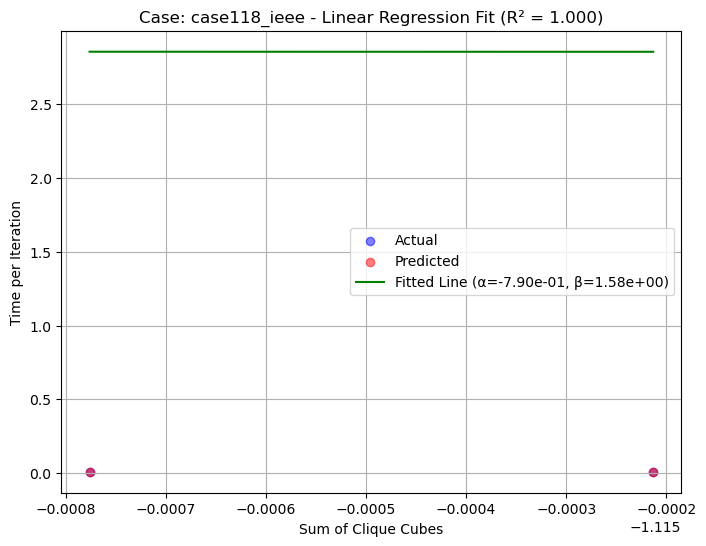

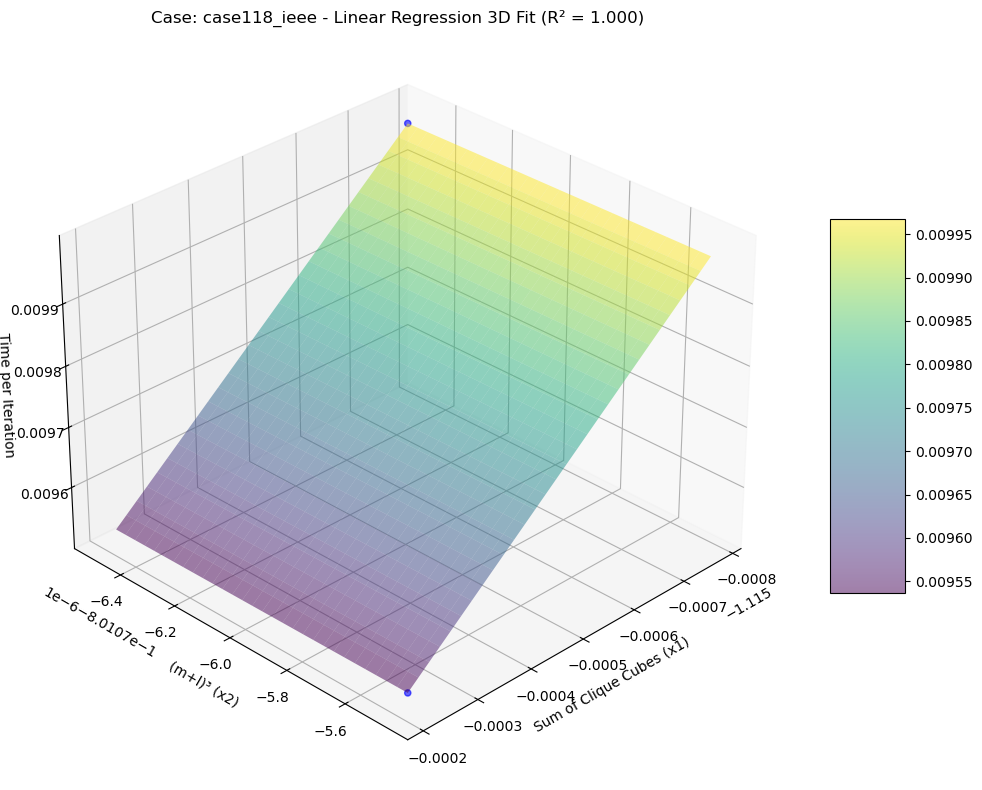

Scaled α = 0.007, β = 0.007, c = 0.083
R² = 1.0


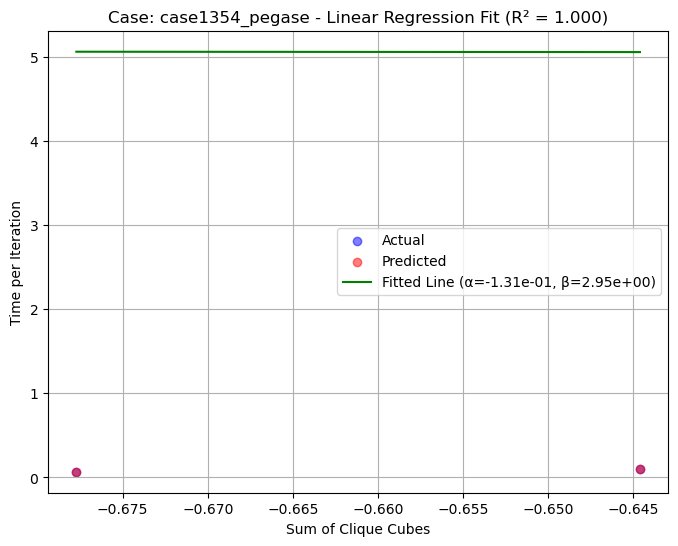

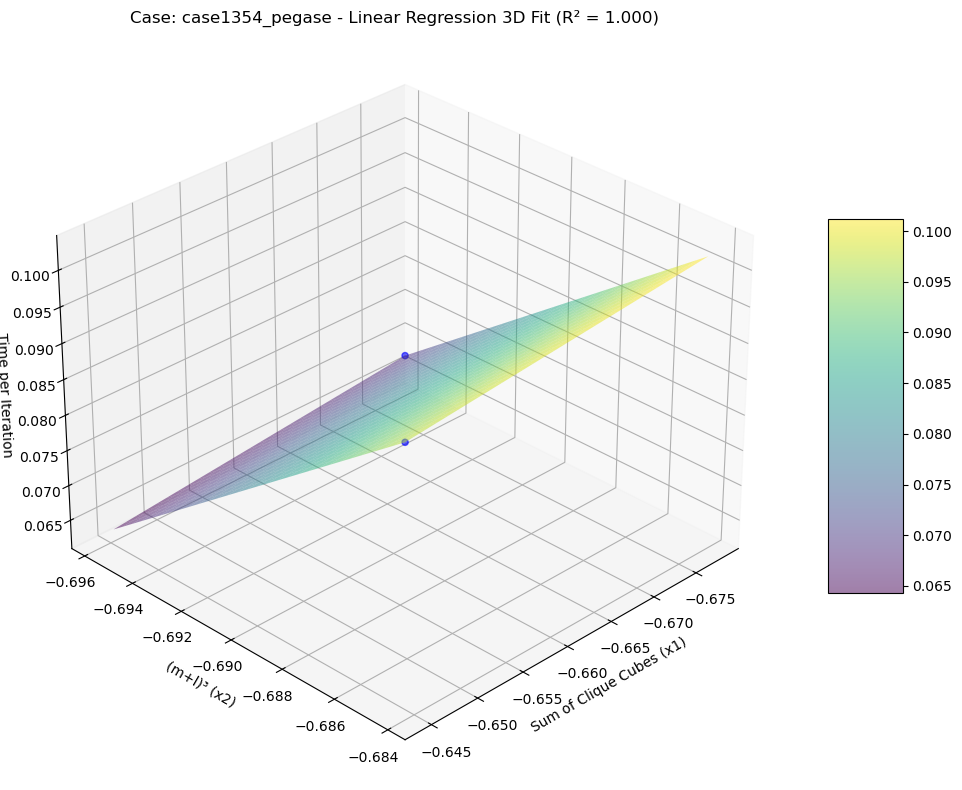

Scaled α = 0.005, β = 0.005, c = 0.097
R² = 1.0


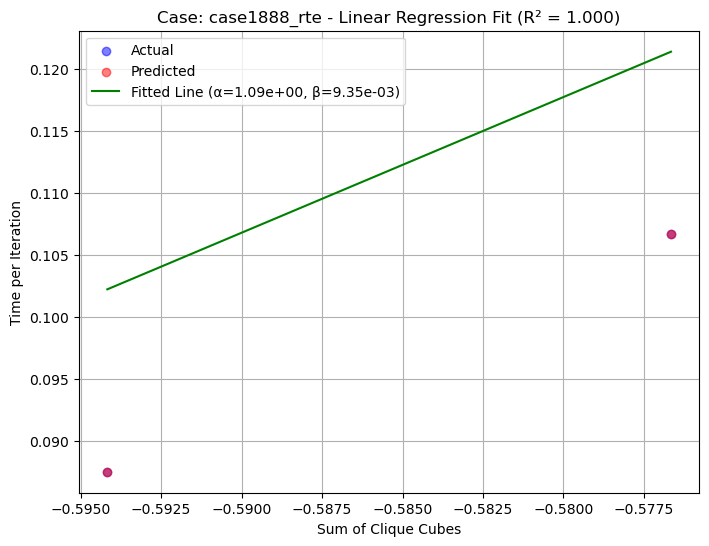

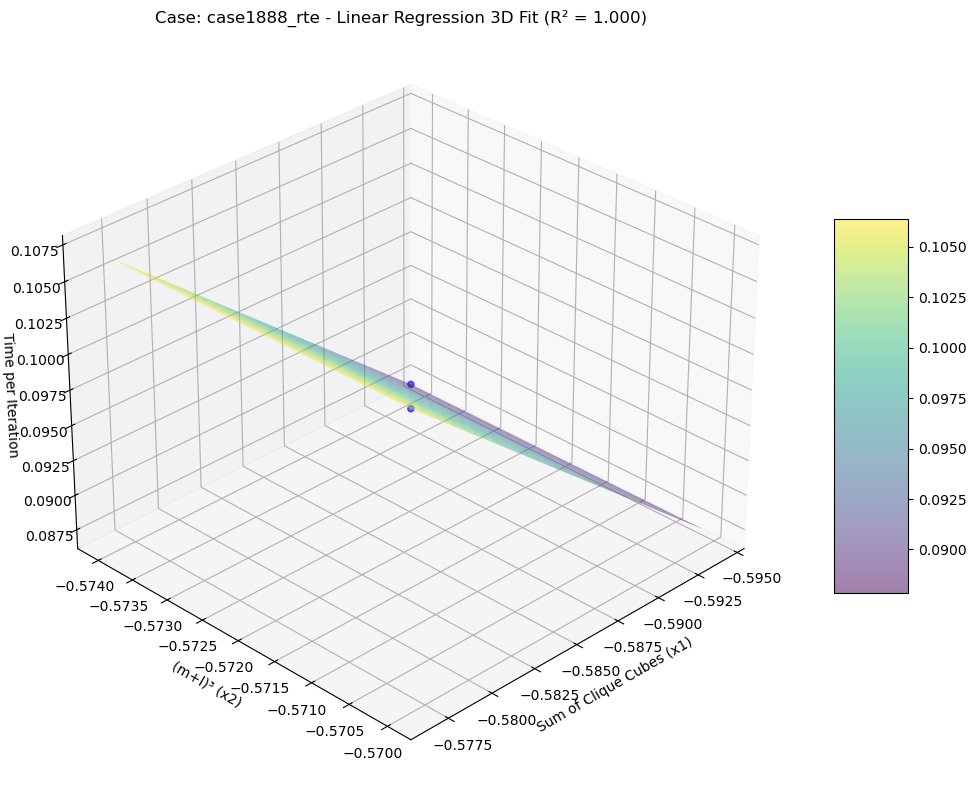

Scaled α = 0.001, β = 0.001, c = 0.096
R² = 1.0


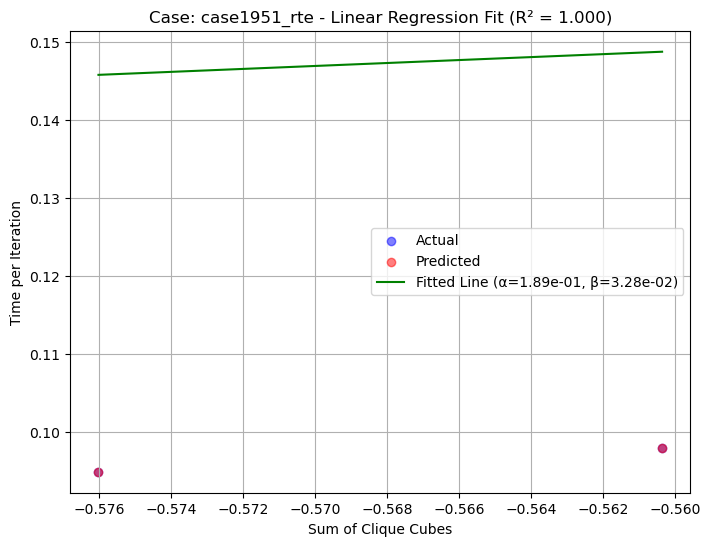

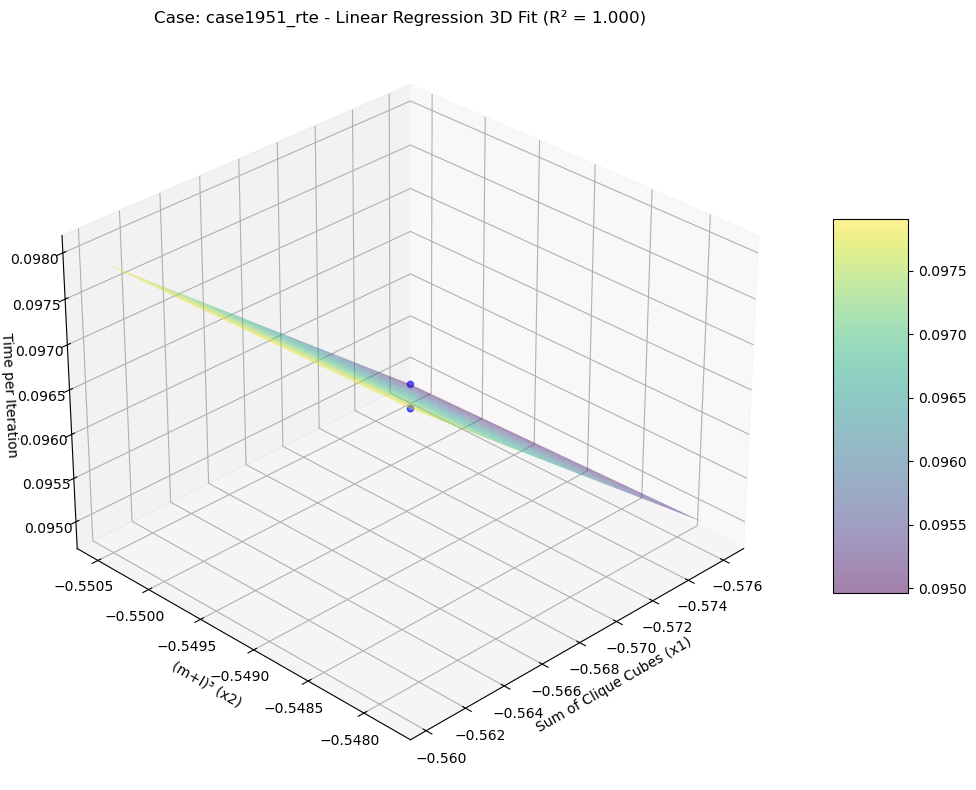

Scaled α = -0.015, β = -0.015, c = 0.353
R² = 1.0


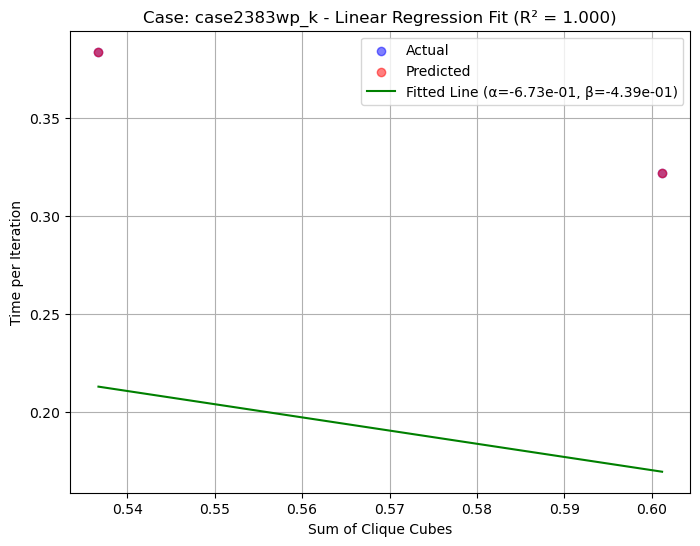

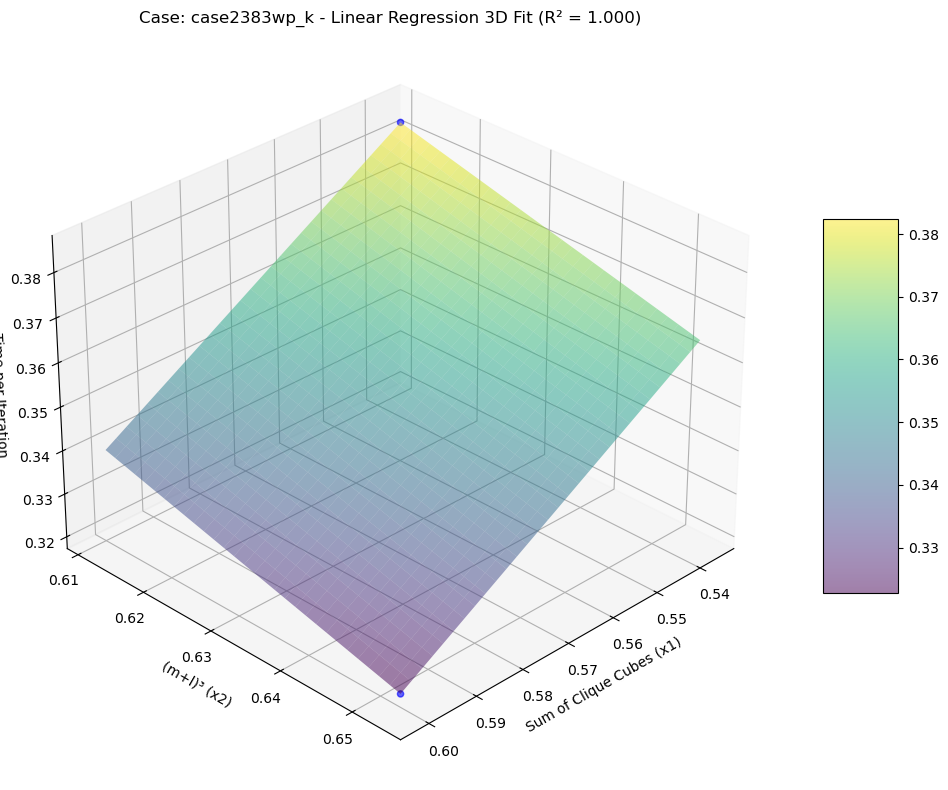

Scaled α = 0.012, β = 0.012, c = 0.447
R² = 1.0


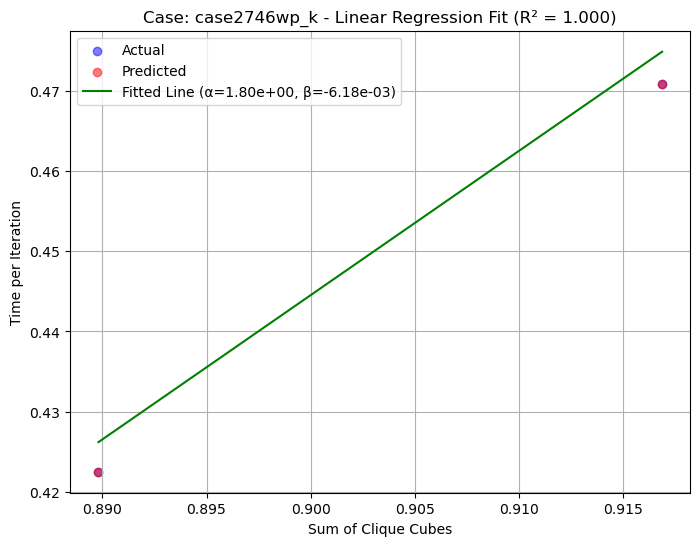

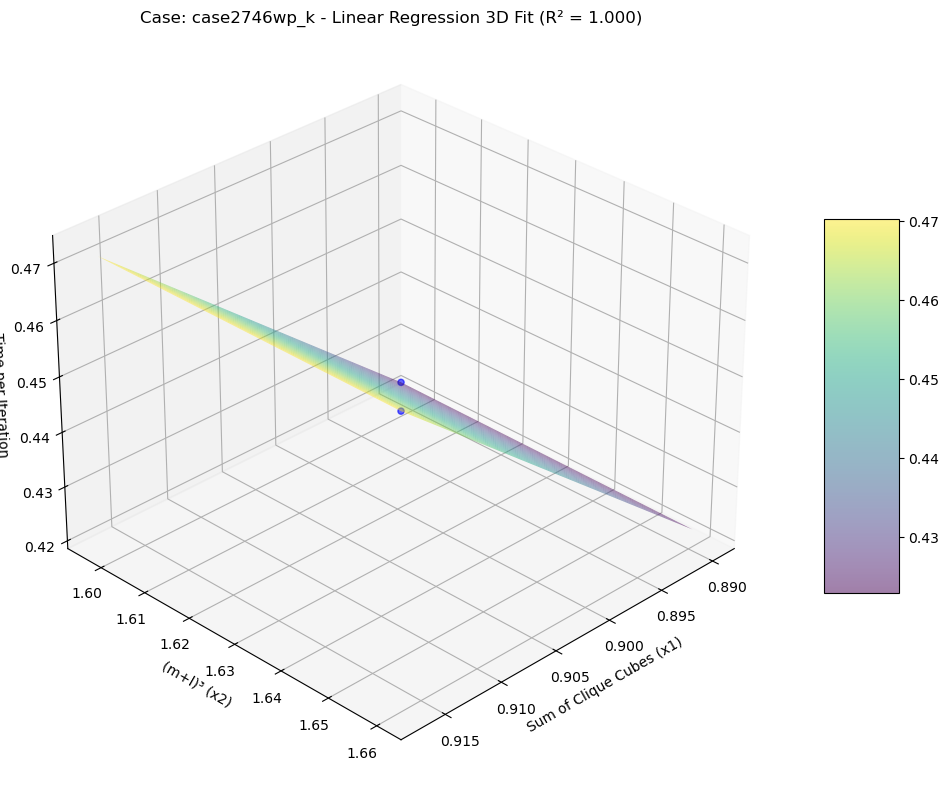

Estimated parameters per Case:
           Case     alpha      beta         c  R2
   case118_ieee -0.790050  1.579974  0.394135 1.0
case1354_pegase -0.130951  2.946374  2.029065 1.0
   case1888_rte  1.094973  0.009348  0.743484 1.0
   case1951_rte  0.189088  0.032801  0.221888 1.0
   case2383wp_k -0.672534 -0.439175  1.013025 1.0
   case2746wp_k  1.798146 -0.006182 -1.167623 1.0

Sample of actual vs predicted solve times:
               Case  Formulation  A_parameter  time_per_iteration    t_pred  \
0      case118_ieee  Chordal_AMD          3.0            0.009531  0.009531   
1      case118_ieee  Chordal_MFI          3.0            0.009974  0.009974   
2   case1354_pegase  Chordal_AMD          3.0            0.097563  0.097563   
3   case1354_pegase  Chordal_MFI          3.0            0.068000  0.068000   
4      case1888_rte  Chordal_AMD          3.0            0.106727  0.106727   
5      case1888_rte  Chordal_MFI          3.0            0.087521  0.087521   
6      case1951_rte  C

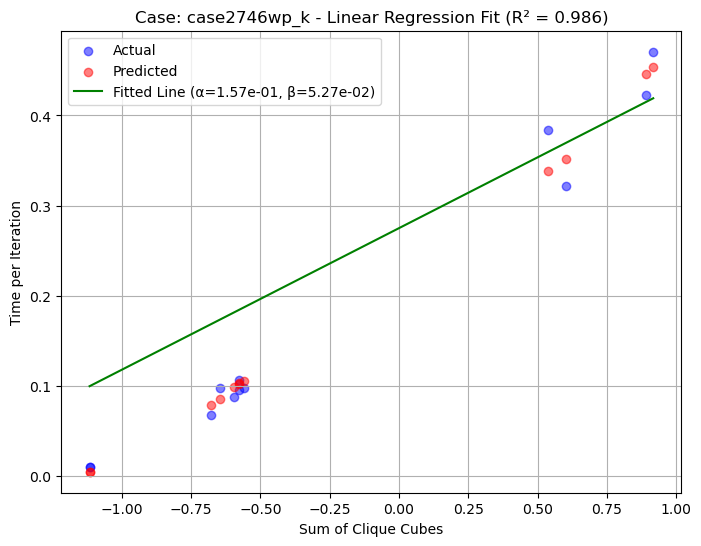

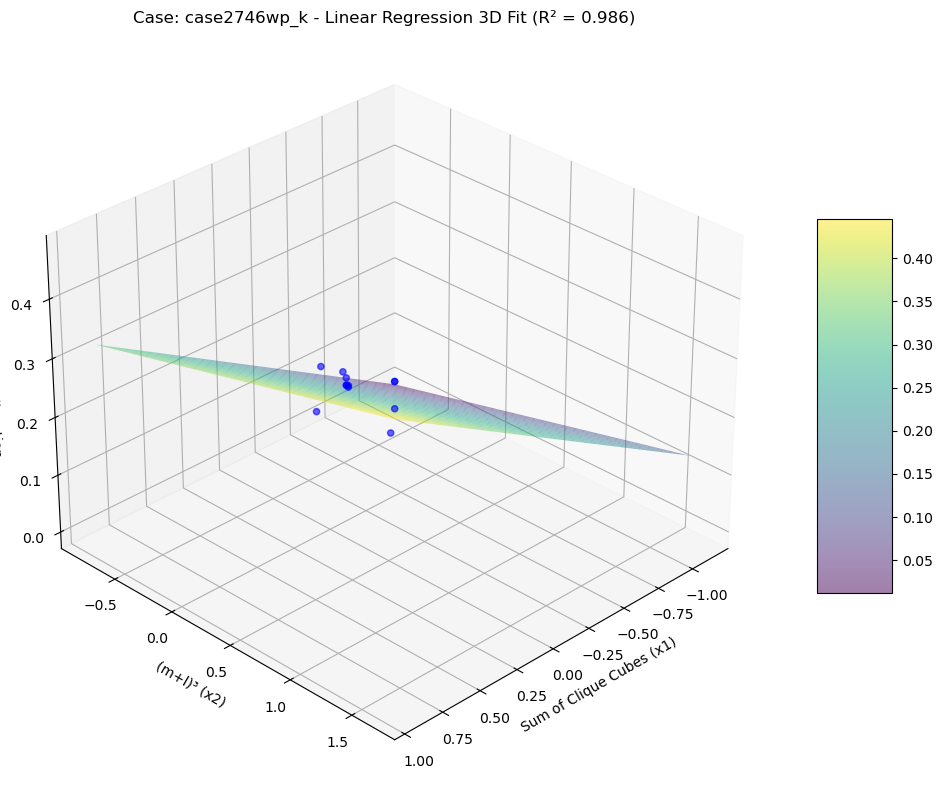

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
# 1) load your CSV (or if you already have df in memory, skip this)
# df = pd.read_csv("alpha_features.csv")
df = pd.read_csv("./Results_raw/Regression_features7.csv")
# 2) compute the second feature

df["x2"] = (df["m"] + df["l"]) ** 3
df["time_per_iteration"] = df["SolveTime"] / df["iterations"]
#normalize x2 and sum_clique_cubes
df["x2"] = (df["x2"] - df["x2"].mean()) / df["x2"].std()
df["sum_clique_cubes"] = (df["sum_clique_cubes"] - df["sum_clique_cubes"].mean()) / df["sum_clique_cubes"].std()   
df_copy = df.copy()
# 2.1) compute the sum of clique cubes
df_copy["sum_clique_cubes"] = df_copy.filter(like="clique_cube_").sum(axis=1)
# 3) for each case, fit and predict
coefs = []
pred_dfs = []
df=df[df["A_parameter"] ==3]  # filter out cases with A_parameter = 0
for case, group in df.groupby("Case"):
    X = group[["sum_clique_cubes", "x2"]]
    y = group["time_per_iteration"]
    lr = LinearRegression(fit_intercept=True).fit(X, y)
    alpha, beta = lr.coef_
    c = lr.intercept_
    y_pred = lr.predict(X)
    r2 = r2_score(y, y_pred)

    # store α,β,c and R²
    coefs.append({
        "Case": case,
        "alpha": alpha,
        "beta": beta,
        "c": c,
        "R2": r2
    })

    # attach predictions & residuals
    g2 = group.copy()
    g2["t_pred"] = y_pred
    g2["residual"] = y - y_pred
    pred_dfs.append(g2)
    pipe = make_pipeline(
        StandardScaler(),
        LinearRegression(fit_intercept=True)
    )

    pipe.fit(X, y)

    # retrieve scaled‐feature coefficients
    lr = pipe.named_steps["linearregression"]
    alpha_p, beta_p = lr.coef_
    c_p = lr.intercept_

    print(f"Scaled α = {alpha_p:.3f}, β = {beta_p:.3f}, c = {c_p:.3f}")

    # compute R² on the scaled model
    y_pred = pipe.predict(X)
    print("R² =", r2_score(y, y_pred))
    
    #plot the points againts the fitted line
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 6))
    plt.scatter(X["sum_clique_cubes"], y, label="Actual", color='blue', alpha=0.5)
    plt.scatter(X["sum_clique_cubes"], y_pred, label="Predicted", color='red', alpha=0.5)
    
    # Add fitted line
    x_range = np.linspace(min(X["sum_clique_cubes"]), max(X["sum_clique_cubes"]), 100)
    y_fitted = alpha * x_range + beta * np.ones_like(x_range) + c
    plt.plot(x_range, y_fitted, 'g-', label=f'Fitted Line (α={alpha:.2e}, β={beta:.2e})')
    
    plt.xlabel("Sum of Clique Cubes")
    plt.ylabel("Time per Iteration")
    plt.title(f"Case: {case} - Linear Regression Fit (R² = {r2:.3f})")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Create a 3D plot to visualize the relationship

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot of actual data points
    ax.scatter(X["sum_clique_cubes"], X["x2"], y, c='blue', marker='o', alpha=0.6, label='Actual data')

    # Create a mesh grid to plot the prediction surface
    x1_range = np.linspace(min(X["sum_clique_cubes"]), max(X["sum_clique_cubes"]), 30)
    x2_range = np.linspace(min(X["x2"]), max(X["x2"]), 30)
    x1_mesh, x2_mesh = np.meshgrid(x1_range, x2_range)
    
    # Predict on the mesh grid
    x1_flat = x1_mesh.flatten()
    x2_flat = x2_mesh.flatten()
    mesh_pred = np.array([alpha * x1 + beta * x2 + c for x1, x2 in zip(x1_flat, x2_flat)])
    
    # Reshape predictions to match the mesh grid
    z_pred = mesh_pred.reshape(x1_mesh.shape)
    
    # Plot the prediction surface
    surface = ax.plot_surface(x1_mesh, x2_mesh, z_pred, alpha=0.5, cmap='viridis', 
                            label='Fitted plane')
    
    # Add colorbar
    fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)
    
    # Set labels
    ax.set_xlabel('Sum of Clique Cubes (x1)')
    ax.set_ylabel('(m+l)³ (x2)')
    ax.set_zlabel('Time per Iteration')
    
    # Set title
    ax.set_title(f'Case: {case} - Linear Regression 3D Fit (R² = {r2:.3f})')
    
    # Set aspect ratio for better visualization
    ax.view_init(elev=30, azim=45)
    
    plt.tight_layout()
    plt.show()
# 4) collect results
coef_df = pd.DataFrame(coefs)
results_df = pd.concat(pred_dfs, ignore_index=True)

print("Estimated parameters per Case:")
print(coef_df.to_string(index=False))

print("\nSample of actual vs predicted solve times:")
print(results_df[["Case","Formulation","A_parameter","time_per_iteration","t_pred","residual"]]
      .sort_values(["Case","Formulation","A_parameter"])
      )
X = df[["sum_clique_cubes", "x2"]]
y = df["time_per_iteration"]
lr = LinearRegression(fit_intercept=True).fit(X, y)
alpha, beta = lr.coef_
c = lr.intercept_
y_pred = lr.predict(X)
r2 = r2_score(y, y_pred)

# store α,β,c and R²
coefs.append({
    "Case": case,
    "alpha": alpha,
    "beta": beta,
    "c": c,
    "R2": r2
})

# attach predictions & residuals
g2 = df.copy()
g2["t_pred"] = y_pred
g2["residual"] = y - y_pred
pred_dfs.append(g2)
pipe = make_pipeline(
    StandardScaler(),
    LinearRegression(fit_intercept=True)
)

pipe.fit(X, y)

# retrieve scaled‐feature coefficients
lr = pipe.named_steps["linearregression"]
alpha_p, beta_p = lr.coef_
c_p = lr.intercept_

print(f"Scaled α = {alpha_p:.3f}, β = {beta_p:.3f}, c = {c_p:.3f}")

# compute R² on the scaled model
y_pred = pipe.predict(X)
print("R² =", r2_score(y, y_pred))

#plot the points againts the fitted line
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(X["sum_clique_cubes"], y, label="Actual", color='blue', alpha=0.5)
plt.scatter(X["sum_clique_cubes"], y_pred, label="Predicted", color='red', alpha=0.5)

# Add fitted line
x_range = np.linspace(min(X["sum_clique_cubes"]), max(X["sum_clique_cubes"]), 100)
y_fitted = alpha * x_range + beta * np.ones_like(x_range) + c
plt.plot(x_range, y_fitted, 'g-', label=f'Fitted Line (α={alpha:.2e}, β={beta:.2e})')

plt.xlabel("Sum of Clique Cubes")
plt.ylabel("Time per Iteration")
plt.title(f"Case: {case} - Linear Regression Fit (R² = {r2:.3f})")
plt.legend()
plt.grid(True)
plt.show()

# Create a 3D plot to visualize the relationship

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of actual data points
ax.scatter(X["sum_clique_cubes"], X["x2"], y, c='blue', marker='o', alpha=0.6, label='Actual data')

# Create a mesh grid to plot the prediction surface
x1_range = np.linspace(min(X["sum_clique_cubes"]), max(X["sum_clique_cubes"]), 30)
x2_range = np.linspace(min(X["x2"]), max(X["x2"]), 30)
x1_mesh, x2_mesh = np.meshgrid(x1_range, x2_range)

# Predict on the mesh grid
x1_flat = x1_mesh.flatten()
x2_flat = x2_mesh.flatten()
mesh_pred = np.array([alpha * x1 + beta * x2 + c for x1, x2 in zip(x1_flat, x2_flat)])

# Reshape predictions to match the mesh grid
z_pred = mesh_pred.reshape(x1_mesh.shape)

# Plot the prediction surface
surface = ax.plot_surface(x1_mesh, x2_mesh, z_pred, alpha=0.5, cmap='viridis', 
                        label='Fitted plane')

# Add colorbar
fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)

# Set labels
ax.set_xlabel('Sum of Clique Cubes (x1)')
ax.set_ylabel('(m+l)³ (x2)')
ax.set_zlabel('Time per Iteration')

# Set title
ax.set_title(f'Case: {case} - Linear Regression 3D Fit (R² = {r2:.3f})')

# Set aspect ratio for better visualization
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

====== Case: case118_ieee ======
====== Linear Regression with model 1===
α = -0.000, β = 0.000, c = 0.010, R² = 0.275
====== Linear Regression with model 2===
α = -0.056, β = -0.213, γ = 0.281, c = 0.215, R² = 0.819
Random Forest R² = 0.931
Feature importances from Random Forest:
                  importance
x2                  0.601365
sum_clique_cubes    0.398635
====== Case: case1354_pegase ======
====== Linear Regression with model 1===
α = 0.028, β = 0.031, c = 0.140, R² = 0.206
====== Linear Regression with model 2===
α = 12.213, β = 28.709, γ = -37.651, c = 6.736, R² = 0.823
Random Forest R² = 0.691
Feature importances from Random Forest:
                  importance
x2                  0.506052
sum_clique_cubes    0.493948

Results DataFrame:
              Case  LinearModel1_R2  LinearModel2_R2  RandomForest_R2
0     case118_ieee         0.274896         0.819052         0.931114
1  case1354_pegase         0.206450         0.822827         0.691082
2             Mean         0

/tmp/ipykernel_957822/3665152976.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["x2"]= (df["l"] + df["m"])**3
/tmp/ipykernel_957822/3665152976.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["x2"] = (df["x2"] - df["x2"].mean()) / df["x2"].std()
/tmp/ipykernel_957822/3665152976.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

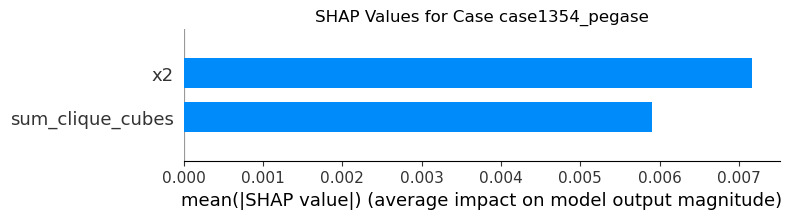

In [8]:
df_full = pd.read_csv("./Results_raw/Regression_features8.csv")
#initialize a table for the results where we store the R2 lines = cases, columns = model tested
#Initialize a DataFrame to store the results
result = []

for case in df_full["Case"].unique():
    df= df_full[df_full["Case"] == case]
    print ("====== Case:", case, "======")
    #Standardize the features
    df["x2"]= (df["l"] + df["m"])**3
    df["x2"] = (df["x2"] - df["x2"].mean()) / df["x2"].std()
    df["l"] = df["l"]-df["l"].mean()
    df["m"] = df["m"]-df["m"].mean()
    df["sc_2"] = df["sc_2"]-df["sc_2"].mean()
    df["l"] = df["l"] / df["l"].std()
    df["m"] = df["m"] / df["m"].std()
    df["sc_2"] = df["sc_2"] / df["sc_2"].std()
    df["sum_clique_cubes"] = df["sum_clique_cubes"] - df["sum_clique_cubes"].mean()
    df["sum_clique_cubes"] = df["sum_clique_cubes"] / df["sum_clique_cubes"].std()
    df["time_per_iteration"] = df["SolveTime"] / df["iterations"]
    
    
    print("====== Linear Regression with model 1===")
    X = df[["sum_clique_cubes", "x2"]]
    y = df["time_per_iteration"]
    lr = LinearRegression(fit_intercept=True).fit(X, y)
    alpha, beta = lr.coef_
    c = lr.intercept_
    y_pred = lr.predict(X)
    r2 = r2_score(y, y_pred)
    print(f"α = {alpha:.3f}, β = {beta:.3f}, c = {c:.3f}, R² = {r2:.3f}")
    
    
    print("====== Linear Regression with model 2===")
    X_2 = df[["l", "m", "sc_2"]]
    y_2 = df["SolveTime"]
    lr_2 = LinearRegression(fit_intercept=True).fit(X_2, y_2)
    alpha_2, beta_2, gamma_2 = lr_2.coef_
    c = lr_2.intercept_
    y_pred_2 = lr_2.predict(X_2)
    r2_2 = r2_score(y_2, y_pred_2)

    print(f"α = {alpha_2:.3f}, β = {beta_2:.3f}, γ = {gamma_2:.3f}, c = {c:.3f}, R² = {r2_2:.3f}")

    #Create RF on the same features 
    from sklearn.ensemble import RandomForestRegressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    rf_pred = rf.predict(X)
    rf_r2 = r2_score(y, rf_pred)
    
    print(f"Random Forest R² = {rf_r2:.3f}")
    
    result.append({
        "Case":             case,
        "LinearModel1_R2":  r2,
        "LinearModel2_R2":  r2_2,
        "RandomForest_R2":  rf_r2
    })
    #make a Shape analysis of the RF values and print the feature importances
    importances = rf.feature_importances_
    feature_importances = pd.DataFrame(importances, index=X.columns, columns=["importance"]).sort_values("importance", ascending=False)
    print("Feature importances from Random Forest:")
    print(feature_importances)
    #Use the SHAP analysis to get the feature importances
    import shap
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, feature_names=X.columns, plot_type="bar", show=False)
    plt.title(f"SHAP Values for Case {case}")
    #plt.show()

#display the results in a DataFrame

#Create a final line of mean R² across all models
mean_r2 = {
    "Case": "Mean",
    "LinearModel1_R2": np.mean([r["LinearModel1_R2"] for r in result]),
    "LinearModel2_R2": np.mean([r["LinearModel2_R2"] for r in result]),
    "RandomForest_R2": np.mean([r["RandomForest_R2"] for r in result])
}
result.append(mean_r2)
result_df = pd.DataFrame(result)
print("\nResults DataFrame:")
print(result_df)


In [3]:
import plotly.graph_objects as go
df = df[df["Case"] != "case2383wp_k"]
rf = RandomForestRegressor(n_estimators=100, random_state=42)
X = df[["x1","x2"]].values
y = df["time_per_iteration"].values
rf.fit(X, y)

# Create the grid for the RF surface
x1g, x2g = np.meshgrid(
    np.linspace(df.x1.min(), df.x1.max(), 30),
    np.linspace(df.x2.min(), df.x2.max(), 30)
)
pts = np.column_stack([x1g.ravel(), x2g.ravel()])
z_surf = rf.predict(pts).reshape(x1g.shape)

# Build the Plotly figure
fig = go.Figure()

# 1) scatter of your real data, colored by case
for case, group in df.groupby("Case"):
    fig.add_trace(
        go.Scatter3d(
            x=group["x1"],
            y=group["x2"],
            z=group["time_per_iteration"],
            mode="markers",
            name=case,
            marker=dict(size=4),
            legendgroup=case
        )
    )

# 2) RF prediction surface
fig.add_trace(
    go.Surface(
        x=x1g,
        y=x2g,
        z=z_surf,
        name="RF fit",
        opacity=0.5,
        showscale=False
    )
)

# Layout tweaks
fig.update_layout(
    scene=dict(
        xaxis_title="x1 (sum_clique_cubes)",
        yaxis_title="x2 ((m+l)^3)",
        zaxis_title="Time per iteration"
    ),
    width=800,
    height=600,
    title="3D Scatter + RF Surface",
    legend=dict(x=0.75, y=0.95)
)

fig.show()

In [ ]:


# supposer que df a déjà été chargé et contient x1, x2, time_per_iteration et Case
X_cols = ["sum_clique_cubes", "x2"]

r2_per_case = []
for case, grp in df.groupby("Case"):
    X = grp[X_cols].values
    y = grp["time_per_iteration"].values

    # entraîner un RF sur ce seul case
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    y_pred = rf.predict(X)

    r2 = r2_score(y, y_pred)
    r2_per_case.append({"Case": case, "R2": r2})

r2_df = pd.DataFrame(r2_per_case)
print(r2_df)


            Case        R2
0  case2746wop_k  0.847064
1   case2746wp_k  0.871864
2   case2848_rte  0.920867
3   case2868_rte  0.927558


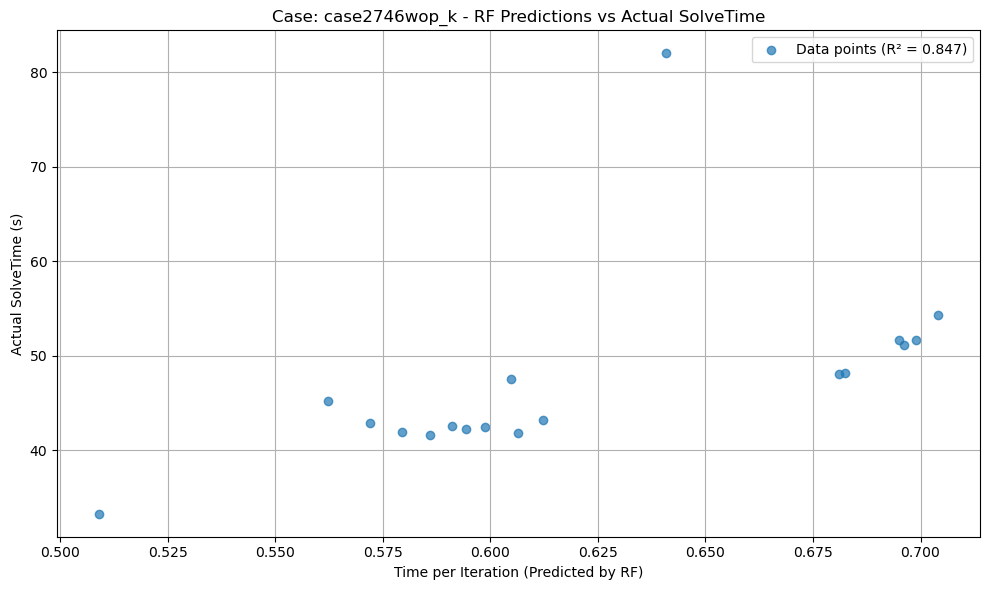

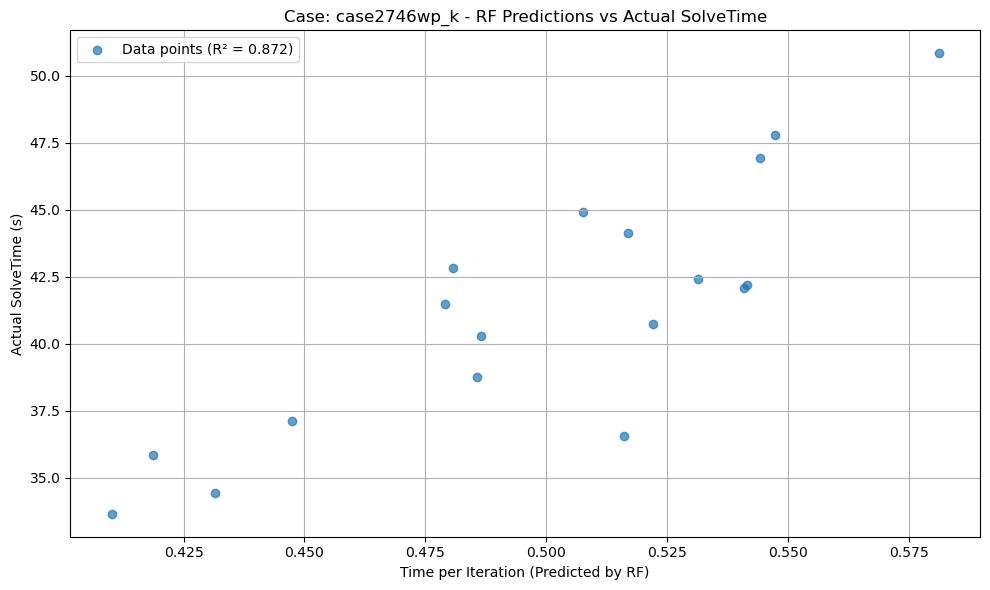

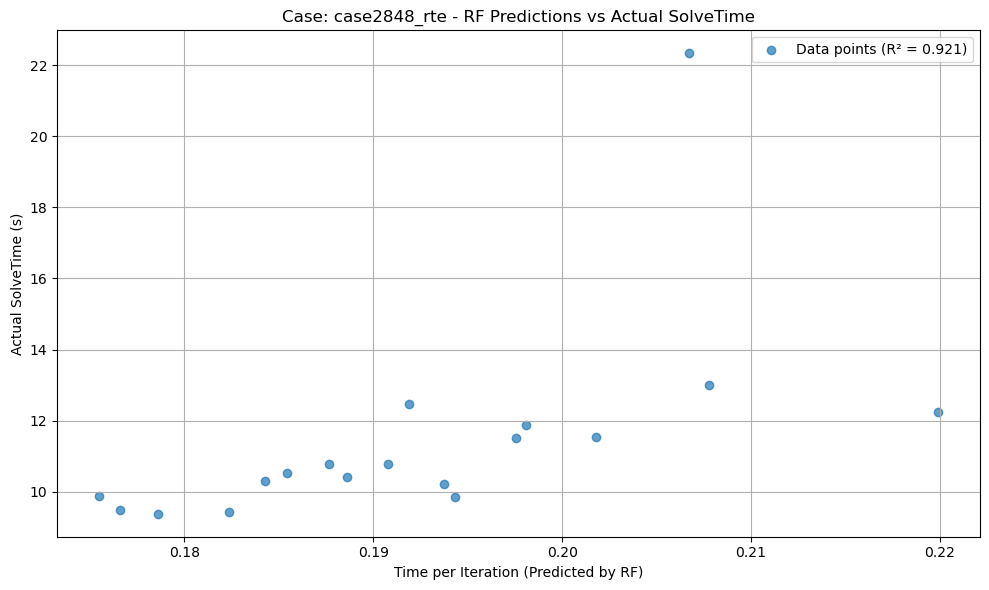

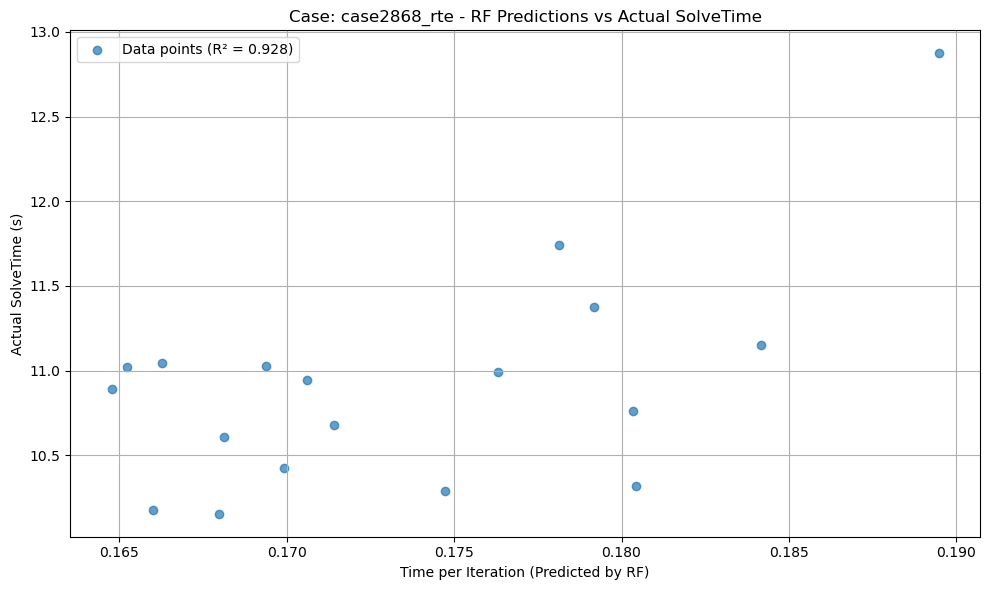

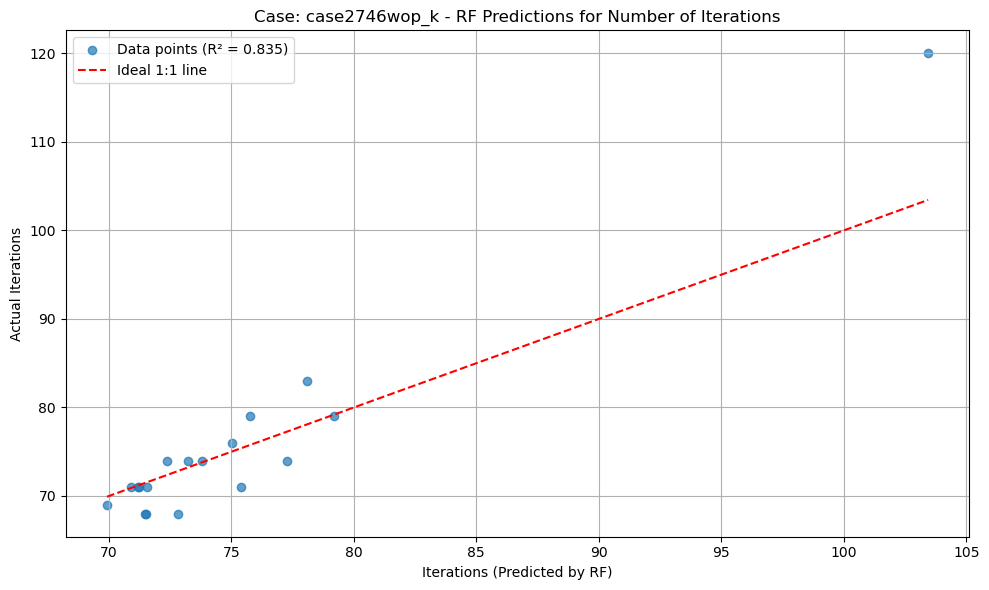

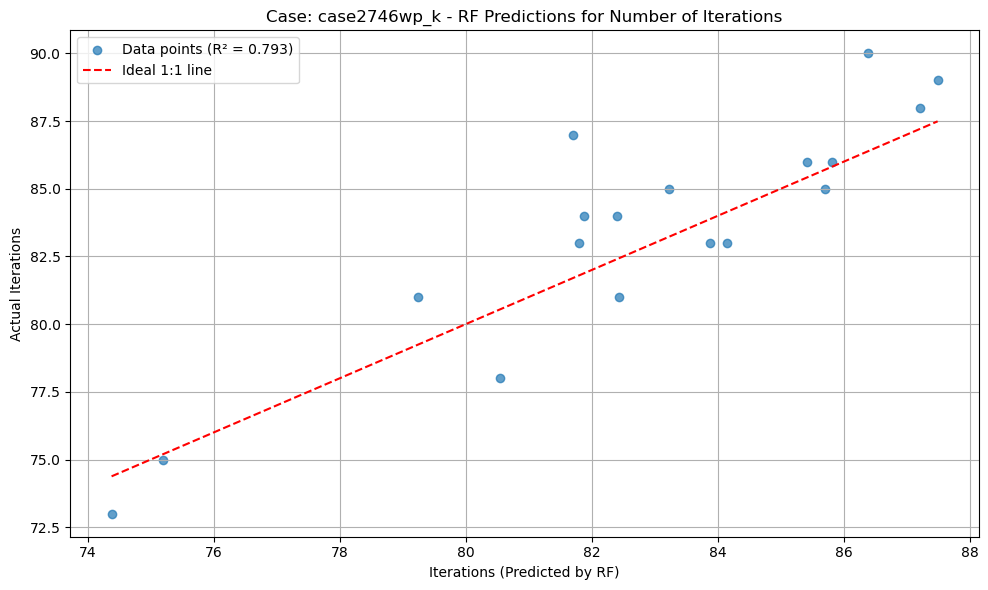

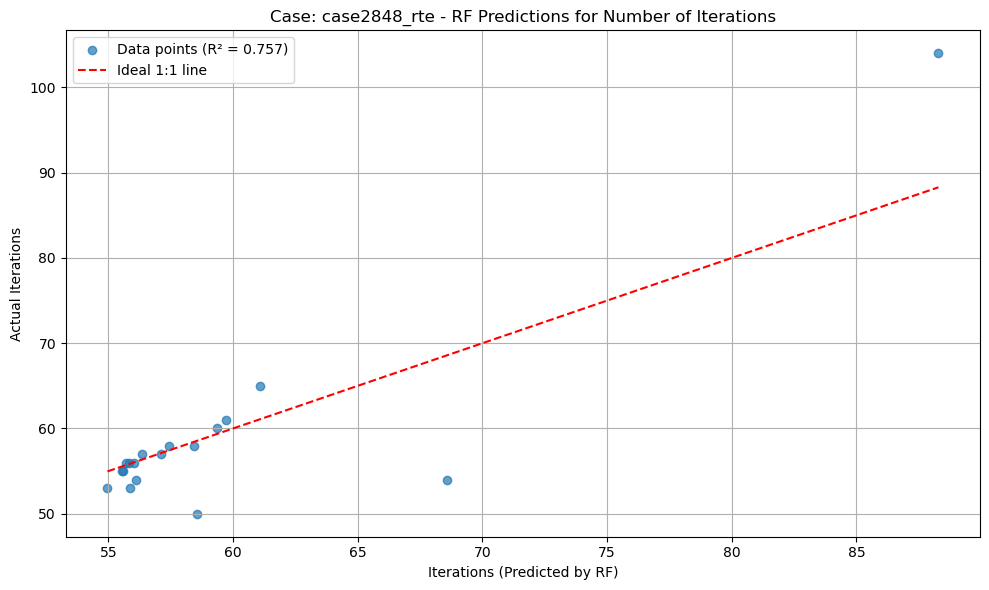

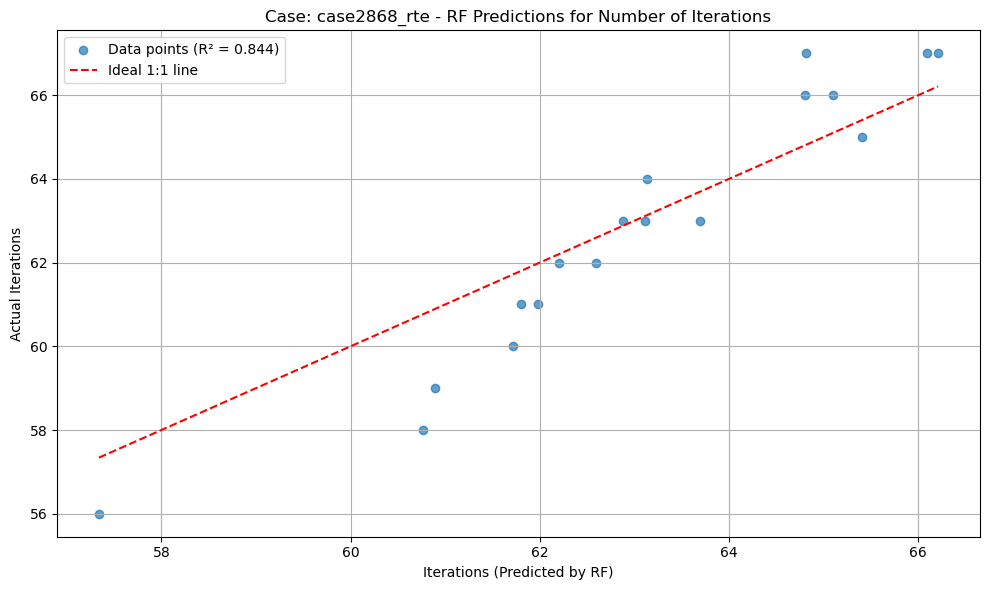

Global model R² for iterations prediction: 0.921
R² per case using global model:
            Case  R2_global
0  case2746wop_k   0.894071
1   case2746wp_k   0.691226
2   case2848_rte   0.826509
3   case2868_rte  -0.106188


In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Define a function to create a scatter plot per case
def plot_rf_predictions_by_case(df_case):
    case = df_case["Case"].iloc[0]  # Get case name from the dataframe
    
    # Features already defined
    features = ["sum_clique_cubes", "x2"]
    
    # Train a RandomForest on this specific case only
    rf_case = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_case.fit(df_case[features], df_case["time_per_iteration"])
    
    # Get predictions
    df_case["t_pred_rf_case"] = rf_case.predict(df_case[features])
    
    # Calculate R² for this case
    r2_case = r2_score(df_case["time_per_iteration"], df_case["t_pred_rf_case"])
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df_case["t_pred_rf_case"], df_case["SolveTime"], 
                alpha=0.7, label=f"Data points (R² = {r2_case:.3f})")
    
    
    plt.xlabel("Time per Iteration (Predicted by RF)")
    plt.ylabel("Actual SolveTime (s)")
    plt.title(f"Case: {case} - RF Predictions vs Actual SolveTime")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Apply the function to each case
for case, df_case in df.groupby("Case"):
    plot_rf_predictions_by_case(df_case)
    
    # This section extends our analysis to predict the number of iterations

# Define a function to create a scatter plot for iterations prediction
def plot_rf_iterations_by_case(df_case):
    case = df_case["Case"].iloc[0]  # Get case name from the dataframe
    
    # Features to use for prediction
    features = ["sum_clique_cubes", "x2"]
    
    # Train a RandomForest to predict iterations for this specific case
    rf_case = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_case.fit(df_case[features], df_case["iterations"])
    
    # Get predictions
    df_case["iter_pred_rf"] = rf_case.predict(df_case[features])
    
    # Calculate R² for this case
    r2_case = r2_score(df_case["iterations"], df_case["iter_pred_rf"])
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df_case["iter_pred_rf"], df_case["iterations"], 
                alpha=0.7, label=f"Data points (R² = {r2_case:.3f})")
    
    #Plot the ideal 1:1 line that starts from the smallest predicted value to the largest
    min_pred = df_case["iter_pred_rf"].min()
    max_pred = df_case["iter_pred_rf"].max()
    plt.plot([min_pred, max_pred], [min_pred, max_pred], 'r--', label='Ideal 1:1 line')
    
    plt.xlabel("Iterations (Predicted by RF)")
    plt.ylabel("Actual Iterations")
    plt.title(f"Case: {case} - RF Predictions for Number of Iterations")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Apply the function to each case
for case, df_case in df.groupby("Case"):
    plot_rf_iterations_by_case(df_case)

# Also train a global model and evaluate its performance
# Create a global RF model for iterations
rf_iter = RandomForestRegressor(n_estimators=100, random_state=42)
rf_iter.fit(df[["sum_clique_cubes", "x2"]], df["iterations"])

# Get predictions
df["iter_pred_rf_global"] = rf_iter.predict(df[["sum_clique_cubes", "x2"]])

# Calculate global R²
r2_global = r2_score(df["iterations"], df["iter_pred_rf_global"])
print(f"Global model R² for iterations prediction: {r2_global:.3f}")

# Calculate R² per case for the global model
r2_global_per_case = []
for case, grp in df.groupby("Case"):
    r2 = r2_score(grp["iterations"], grp["iter_pred_rf_global"])
    r2_global_per_case.append({"Case": case, "R2_global": r2})

r2_global_df = pd.DataFrame(r2_global_per_case)
print("R² per case using global model:")
print(r2_global_df)

In [ ]:
import pprint as pprint
pprint.pprint(df_copy.head())

   Formulation           Case  Merge  A_parameter  n_cliques  \
0  Chordal_AMD  case2746wop_k   True          1.5       1668   
1  Chordal_AMD  case2746wop_k   True          1.8       1707   
2  Chordal_AMD  case2746wop_k   True          2.1       1794   
3  Chordal_AMD  case2746wop_k   True          2.4       2437   
4  Chordal_AMD  case2746wop_k   True          2.7       2491   

   sum_clique_cubes  SolveTime         Status   objective  \
0               0.0  51.716291  SLOW_PROGRESS  119.014655   
1               0.0  41.800640  SLOW_PROGRESS  120.815751   
2               0.0  42.458642  SLOW_PROGRESS  120.823591   
3               0.0  43.192088  SLOW_PROGRESS  120.818091   
4               0.0  48.091338  SLOW_PROGRESS  120.811892   

           primal_status  iterations      m      l                x2  \
0  UNKNOWN_RESULT_STATUS          68  76324  29849  1196857006599717   
1  UNKNOWN_RESULT_STATUS          68  72511  27945  1013742475618816   
2  UNKNOWN_RESULT_STATUS        

R² for iterations prediction: 0.922
R² for time per iteration prediction: 0.977
R² for combined prediction (SolveTime): 0.987


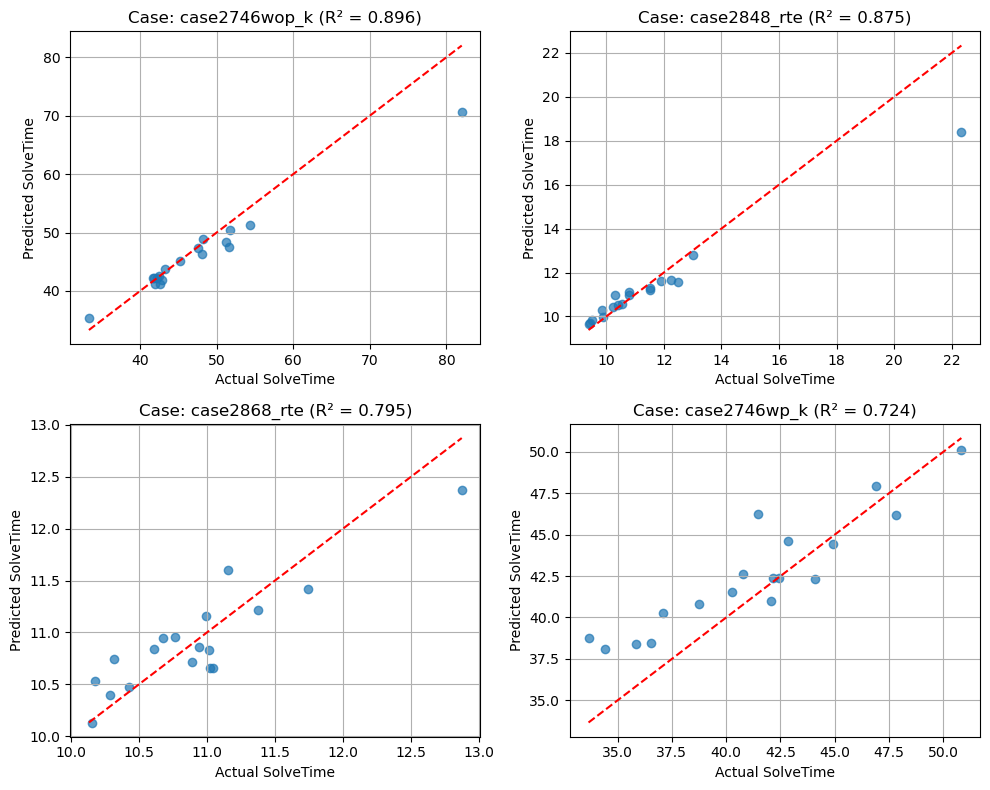

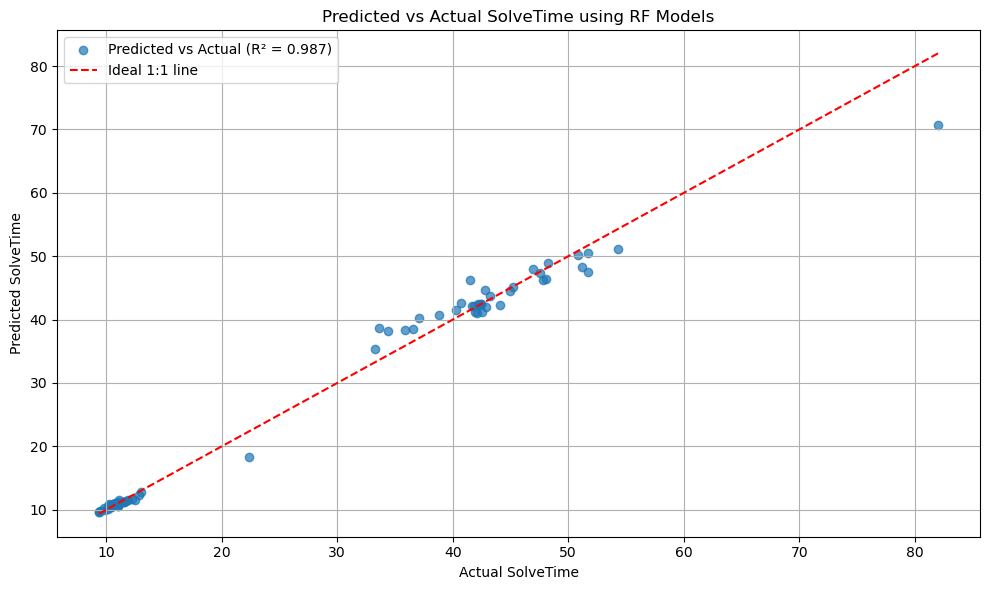

R² for SolveTime prediction: 0.987


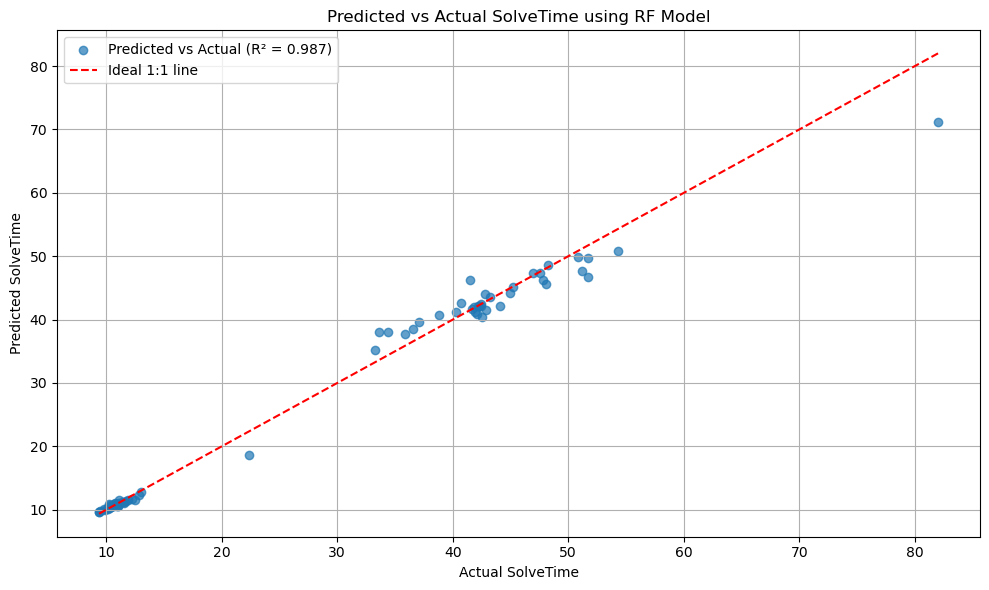

In [6]:
from matplotlib.gridspec import GridSpec
import numpy as np

rf_iter = RandomForestRegressor(n_estimators=100, random_state=42)
rf_time_iter = RandomForestRegressor(n_estimators=100, random_state=42)
X = df_copy[["sum_clique_cubes", "x2"]].values
y_iter = df_copy["iterations"].values
y_time_iter = df_copy["time_per_iteration"].values

rf_iter.fit(X, y_iter)
rf_time_iter.fit(X, y_time_iter)

y_iter_pred = rf_iter.predict(X)
y_time_iter_pred = rf_time_iter.predict(X)
#R² for iterations prediction
r2_iter = r2_score(y_iter, y_iter_pred)
print(f"R² for iterations prediction: {r2_iter:.3f}")
#R² for time per iteration prediction
r2_time_iter = r2_score(y_time_iter, y_time_iter_pred)
print(f"R² for time per iteration prediction: {r2_time_iter:.3f}")

time_pred = y_iter_pred * y_time_iter_pred

# Calculate R² for the combined prediction
r2_combined = r2_score(df_copy["SolveTime"], time_pred)
print(f"R² for combined prediction (SolveTime): {r2_combined:.3f}")

#plot predictions against actual SolveTime for each case
import matplotlib.pyplot as plt

# Create a figure with subplots for each case
cases = df_copy["Case"].unique()
n_cases = len(cases)

# Determine grid layout (roughly square)
n_cols = int(np.ceil(np.sqrt(n_cases)))
n_rows = int(np.ceil(n_cases / n_cols))

fig = plt.figure(figsize=(n_cols * 5, n_rows * 4))
gs = GridSpec(n_rows, n_cols, figure=fig)

# Plot for each case
for i, case in enumerate(cases):
    df_case = df_copy[df_copy["Case"] == case]
    
    row = i // n_cols
    col = i % n_cols
    ax = fig.add_subplot(gs[row, col])
    
    # Select data for this case
    X_case = df_case[["sum_clique_cubes", "x2"]].values
    y_iter_case = df_case["iterations"].values
    y_time_iter_case = df_case["time_per_iteration"].values
    
    # Predict using our global models
    iter_pred_case = rf_iter.predict(X_case)
    time_iter_pred_case = rf_time_iter.predict(X_case)
    time_pred_case = iter_pred_case * time_iter_pred_case
    
    # Calculate R² for this case
    r2_case = r2_score(df_case["SolveTime"], time_pred_case)
    
    # Plot
    ax.scatter(df_case["SolveTime"], time_pred_case, alpha=0.7)
    
    # Plot 1:1 line
    min_val = min(df_case["SolveTime"].min(), time_pred_case.min())
    max_val = max(df_case["SolveTime"].max(), time_pred_case.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    ax.set_title(f"Case: {case} (R² = {r2_case:.3f})")
    ax.set_xlabel("Actual SolveTime")
    ax.set_ylabel("Predicted SolveTime")
    ax.grid(True)

plt.tight_layout()
plt.show()

# Also generate a global plot
plt.figure(figsize=(10, 6))
plt.scatter(df_copy["SolveTime"], time_pred, alpha=0.7, label=f"Predicted vs Actual (R² = {r2_combined:.3f})")
plt.plot([df_copy["SolveTime"].min(), df_copy["SolveTime"].max()], 
         [df_copy["SolveTime"].min(), df_copy["SolveTime"].max()], 'r--', label='Ideal 1:1 line')
plt.xlabel("Actual SolveTime")
plt.ylabel("Predicted SolveTime")
plt.title("Predicted vs Actual SolveTime using RF Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

rf_solve_time = RandomForestRegressor(n_estimators=100, random_state=42)
X = df_copy[["sum_clique_cubes", "x2"]].values
y_solve_time = df_copy["SolveTime"].values

rf_solve_time.fit(X, y_solve_time)

y_solve_time_pred = rf_solve_time.predict(X)
#R² for SolveTime prediction
r2_solve_time = r2_score(y_solve_time, y_solve_time_pred)
print(f"R² for SolveTime prediction: {r2_solve_time:.3f}")
# Plot predictions against actual SolveTime for each case
plt.figure(figsize=(10, 6))
plt.scatter(df_copy["SolveTime"], y_solve_time_pred, alpha=0.7, label=f"Predicted vs Actual (R² = {r2_solve_time:.3f})")
plt.plot([df_copy["SolveTime"].min(), df_copy["SolveTime"].max()], 
         [df_copy["SolveTime"].min(), df_copy["SolveTime"].max()], 'r--', label='Ideal 1:1 line')
plt.xlabel("Actual SolveTime")
plt.ylabel("Predicted SolveTime")
plt.title("Predicted vs Actual SolveTime using RF Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

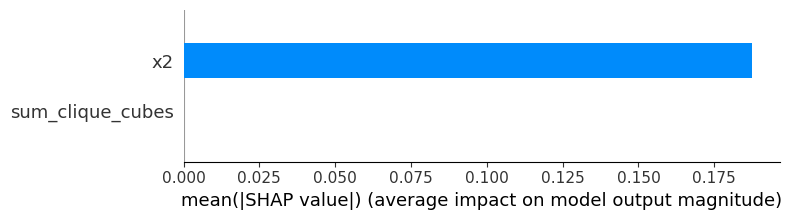

Mean |SHAP| value for sum_clique_cubes: 0.0000
Mean |SHAP| value for x2: 0.1873


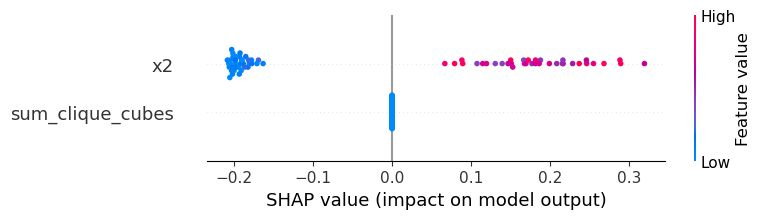

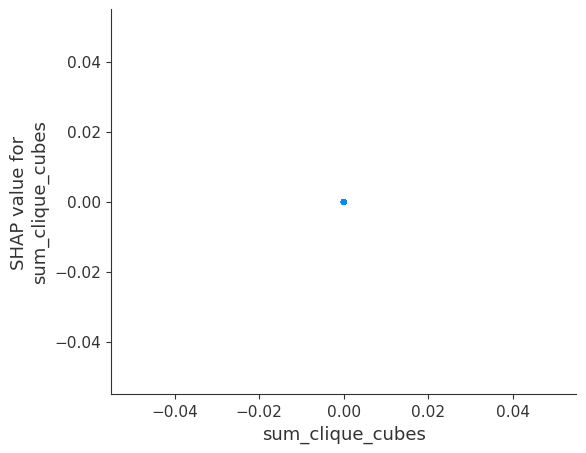

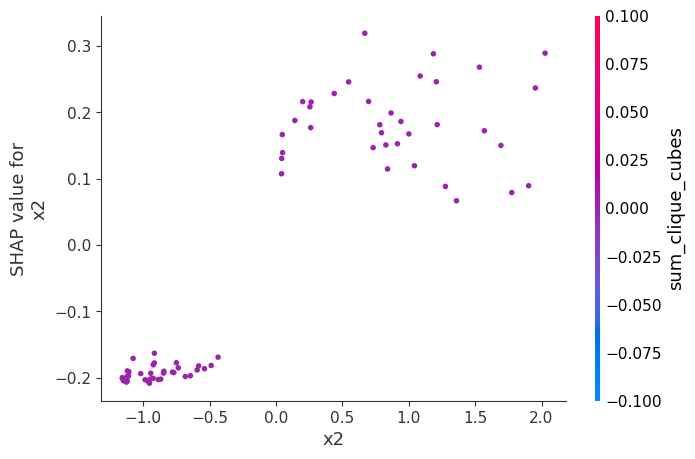

/home/goatoine/anaconda3/envs/OPF_ML/lib/python3.9/site-packages/shap/plots/_force_matplotlib.py:107: RuntimeWarning:

divide by zero encountered in scalar divide



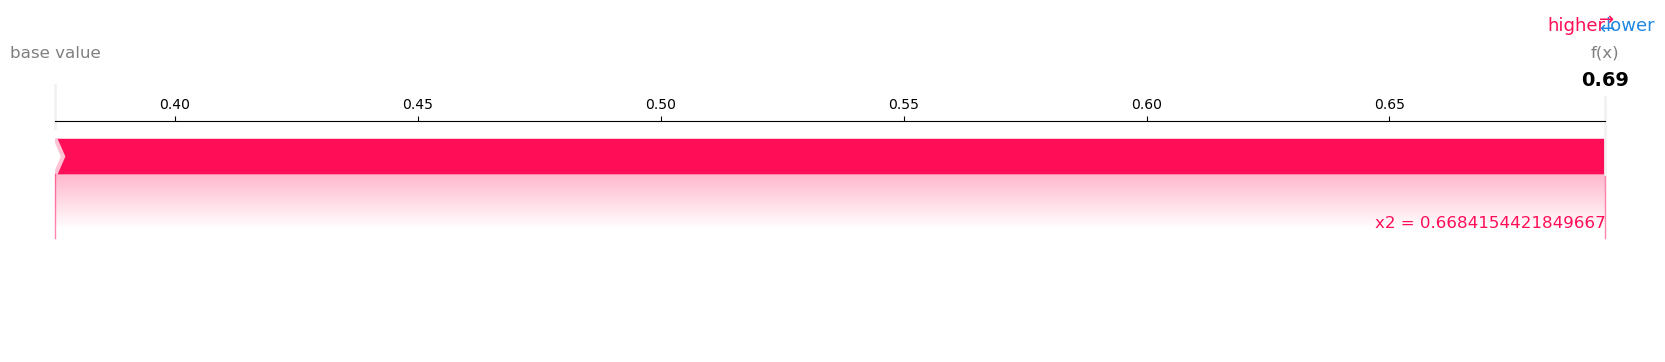

In [8]:
# 1) Install shap if you haven't already:
#    pip install shap

import shap
import matplotlib.pyplot as plt
import numpy as np

# 2) Create a TreeExplainer for your RF model
explainer = shap.TreeExplainer(rf_time_iter)

# 3) Compute SHAP values for your training set
#    This returns an array of shape (N_samples, N_features)
shap_values = explainer.shap_values(X)

# 4) Global feature importance: summary plot
#    Plots a bar chart of mean(|SHAP|) per feature
feature_names = ["sum_clique_cubes", "x2"]
shap.summary_plot(shap_values, X, feature_names=feature_names, plot_type="bar")

# Print mean absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)
for feature, importance in zip(feature_names, mean_abs_shap):
    print(f"Mean |SHAP| value for {feature}: {importance:.4f}")

# 5) Detailed summary: violin‐style plot showing distribution
shap.summary_plot(shap_values, X, feature_names=feature_names)

# 6) Dependence plots: for each feature, show how its value vs. SHAP impact
for i, name in enumerate(feature_names):
    shap.dependence_plot(i, shap_values, X, feature_names=feature_names)

# 7) (Optional) Force plot for a single prediction
#    Choose an index, e.g. idx = 0
idx = 0
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X[idx,:],
    feature_names=feature_names, matplotlib=True
)
plt.show()


['case2746wop_k' 'case2848_rte' 'case2868_rte' 'case2746wp_k']
R² for l and m prediction: 0.819


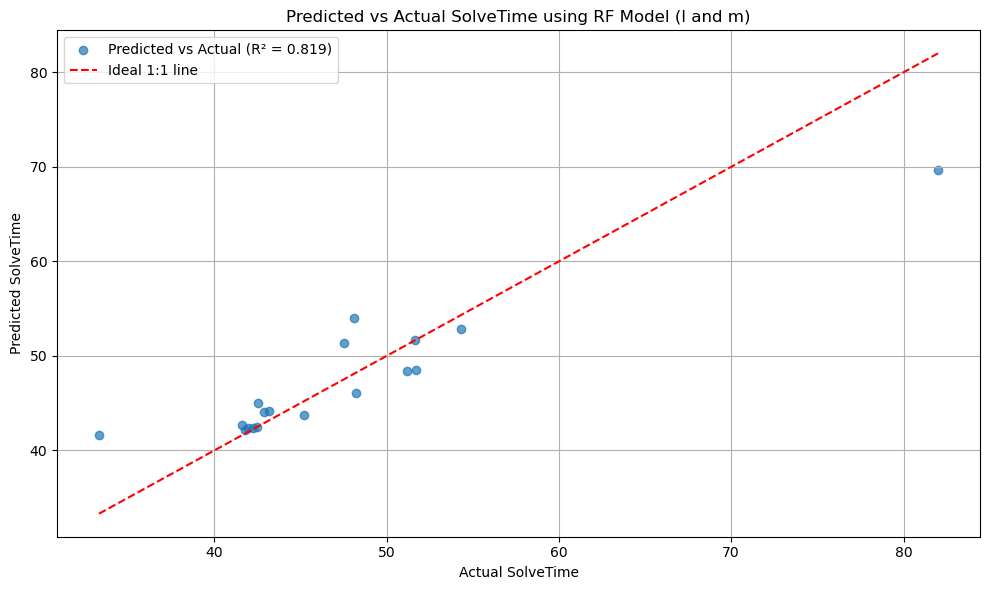

[[-9.01070270e-01  2.75185772e-01  8.11927632e-01  7.57272092e-02
  -3.27440719e+00 -7.31603850e-01  2.08390505e-02]
 [-1.30091335e+00 -1.12230593e+00  1.69237554e+00  1.25957059e+00
   1.15914326e+00 -2.20163393e+00 -1.41362354e+00]
 [-1.21523269e+00 -1.32315183e+00  1.47679049e+00  1.75073078e+00
   9.18437822e-01 -1.79464407e+00 -2.31648264e+00]
 [ 6.68271811e-02 -1.20641931e-01  4.46587214e-03  1.45544756e-02
  -5.53929968e-01  2.98441646e-04 -1.75588004e-03]
 [ 3.12739074e-01  1.07692013e-01  9.78057286e-02  1.15975696e-02
   2.90401365e+00  3.05876730e-02  1.24896561e-03]
 [ 4.89980439e-01  3.33460406e-01  2.40080830e-01  1.11195843e-01
   1.46938116e+00  1.17634911e-01  3.70794108e-02]
 [ 9.27203805e-01  9.32333061e-01  8.59706895e-01  8.69244937e-01
   9.94498472e-01  7.97123504e-01  8.10425793e-01]
 [ 1.44716781e+00  1.67560953e+00  2.09429466e+00  2.80766729e+00
   8.63666496e-01  3.03079582e+00  4.70455405e+00]
 [ 1.52570841e+00  1.81121717e+00  2.32778616e+00  3.28050762e+0

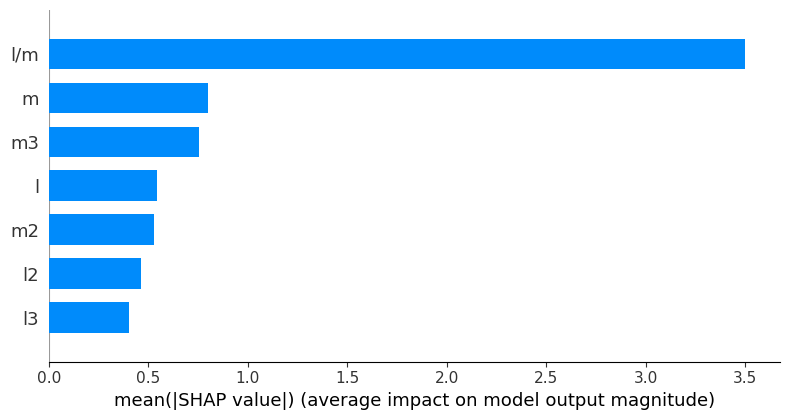

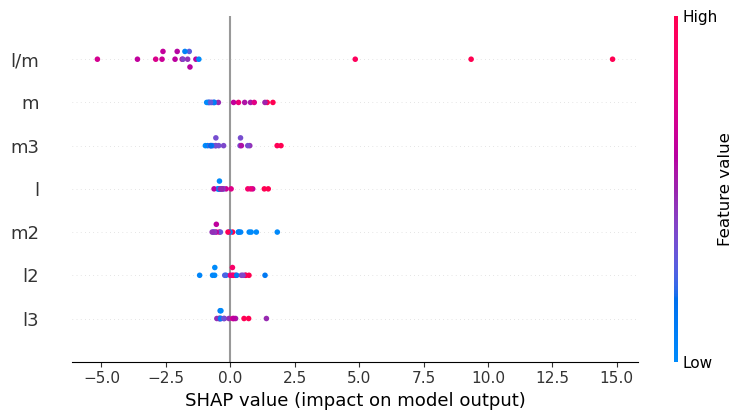

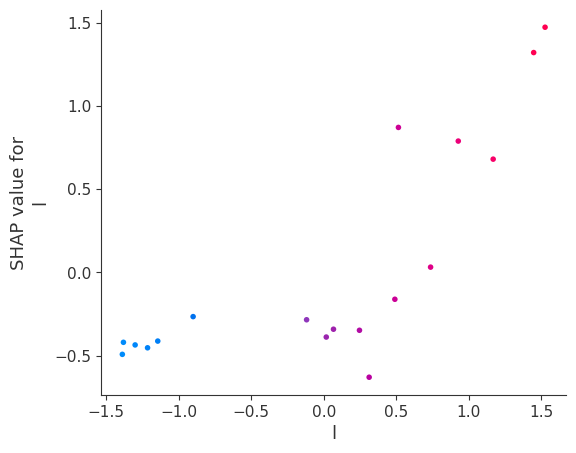

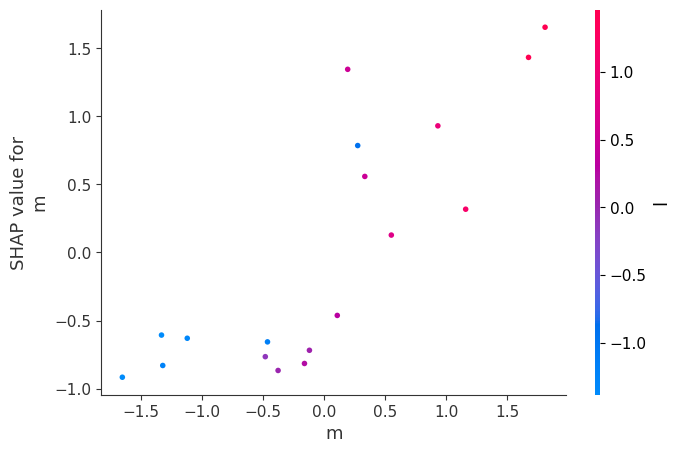

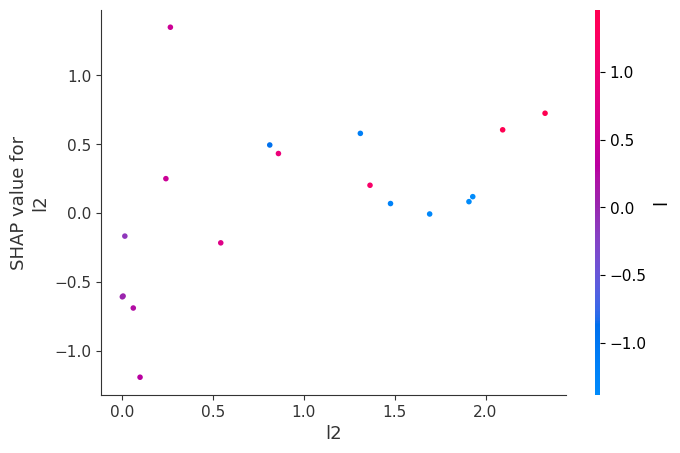

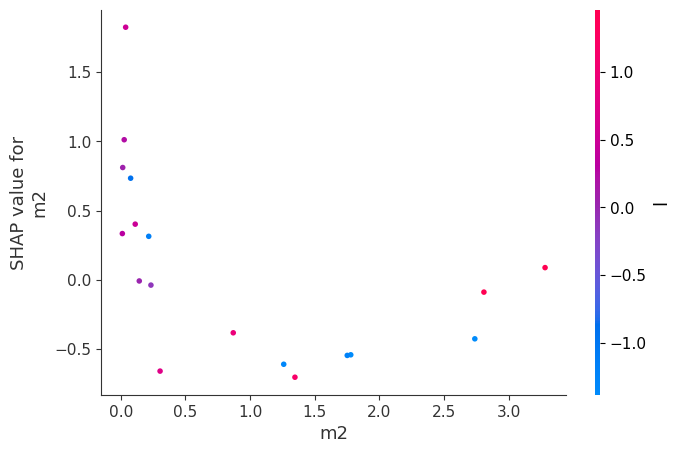

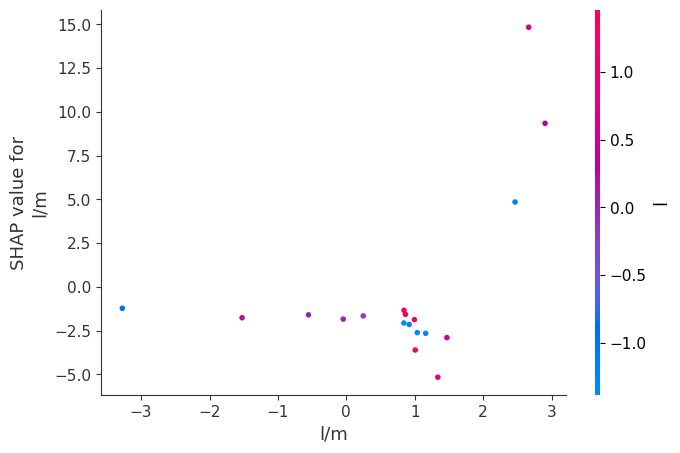

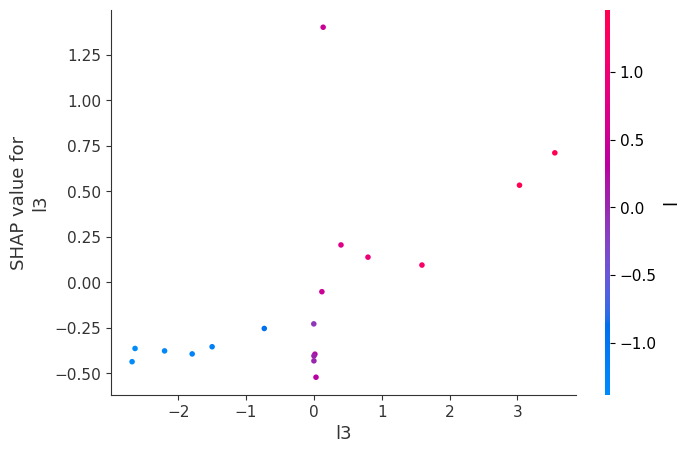

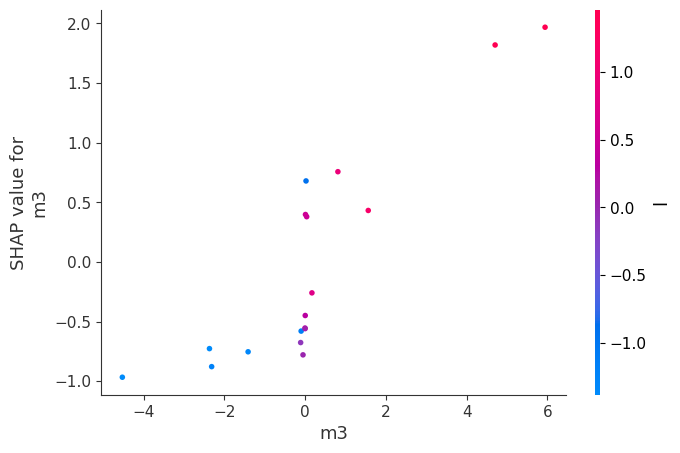

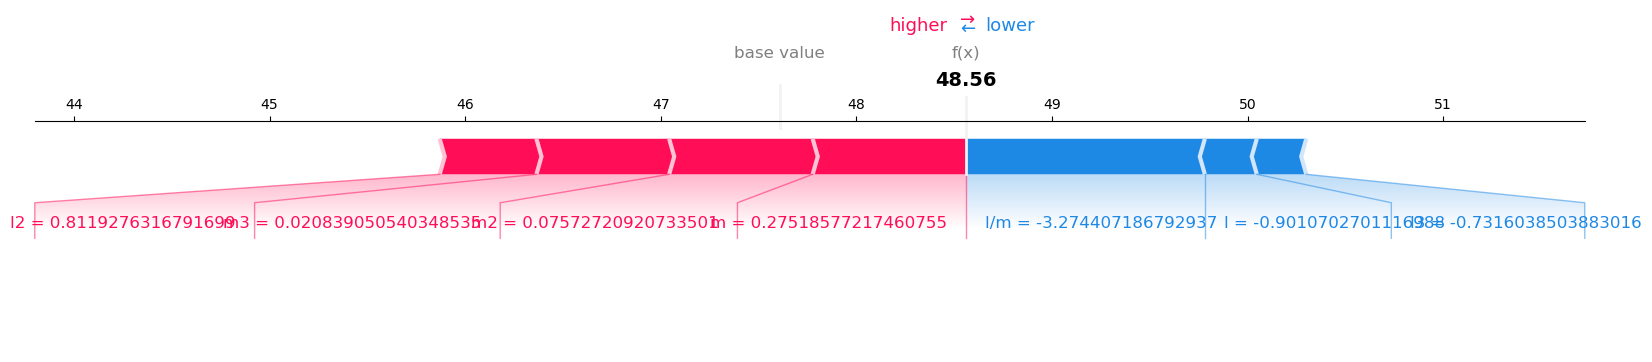

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("./Results_raw/Regression_features4.csv")

rf_l_m= RandomForestRegressor(n_estimators=100, random_state=42)
#normalize l and m 
print(df["Case"].unique())
df = df[df["Case"] == "case2746wop_k"]
df["l"] = (df["l"] - df["l"].mean()) / df["l"].std()
df["m"] = (df["m"] - df["m"].mean()) / df["m"].std()
df["l2"] = df["l"] ** 2
df["m2"] = df["m"] ** 2
df["l/m"] = df["l"] / df["m"]
df["l3"] = df["l"] ** 3
df["m3"] = df["m"] ** 3

X = df[["l", "m", "l2", "m2", "l/m", "l3", "m3"]].values


rf_l_m.fit(X, df["SolveTime"])
y_l_m_pred = rf_l_m.predict(X)
# R² for l and m prediction
r2_l_m = r2_score(df["SolveTime"], y_l_m_pred)
print(f"R² for l and m prediction: {r2_l_m:.3f}")
# Plot predictions against actual SolveTime for l and m
plt.figure(figsize=(10, 6))  
plt.scatter(df["SolveTime"], y_l_m_pred, alpha=0.7, label=f"Predicted vs Actual (R² = {r2_l_m:.3f})")
plt.plot([df["SolveTime"].min(), df["SolveTime"].max()], 
         [df["SolveTime"].min(), df["SolveTime"].max()], 'r--', label='Ideal 1:1 line')
plt.xlabel("Actual SolveTime")
plt.ylabel("Predicted SolveTime")
plt.title("Predicted vs Actual SolveTime using RF Model (l and m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()   

print(X)

# 1) Install shap if you haven’t already:
#    pip install shap

import shap
import matplotlib.pyplot as plt

# 2) Create a TreeExplainer for your RF model
explainer = shap.TreeExplainer(rf_l_m)

# 3) Compute SHAP values for your training set
#    This returns an array of shape (N_samples, N_features)
shap_values = explainer.shap_values(X)

# 4) Global feature importance: summary plot
#    Plots a bar chart of mean(|SHAP|) per feature
feature_names = ["l", "m", "l2", "m2", "l/m", "l3", "m3"]
shap.summary_plot(shap_values, X, feature_names=feature_names, plot_type="bar")

# 5) Detailed summary: violin‐style plot showing distribution
shap.summary_plot(shap_values, X, feature_names=feature_names)

# 6) Dependence plots: for each feature, show how its value vs. SHAP impact
for i, name in enumerate(feature_names):
    shap.dependence_plot(i, shap_values, X, feature_names=feature_names)

# 7) (Optional) Force plot for a single prediction
#    Choose an index, e.g. idx = 0
idx = 0
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X[idx,:],
    feature_names=feature_names, matplotlib=True
)
plt.show()


In [ ]:
#